![Banner](../img/banner/banner.png)


# 01 - Profiling Inicial

## Descripción
Este notebook tiene como objetivo realizar una carga inicial de los datos, estructurarlos (especialmente datos anidados en formato JSON), y realizar un análisis exploratorio rápido utilizando `pandas-profiling`. Además, se documentarán observaciones y hallazgos simples, y se proporcionará un resumen con los siguientes pasos planeados

# 1 - Dependencias:

### 1.1 Instalación de dependencias

In [ ]:
# # Visualizacion
# !pip install ydata_profiling
# # NPL Clasic
# !pip install spacy
# #python -m spacy download es_core_news_lg # model large
# !python -m spacy download es_core_news_sm # model small

### 1.2 Importación de dependencias

In [ ]:
# Complementos
import warnings
from pathlib import Path
import gc

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

# Pre-procesamiento
from typing import List
import re
import json
import ast
import pandas as pd
import numpy as np
from dateutil.parser import parse
from sklearn.impute import KNNImputer

# NPL Clasic
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from collections import Counter

### 1.3 Conexión a Datasets desde Google Drive

In [ ]:
from google.colab import files
from google.colab import drive

# 2 - Funciones:

### 2.1 Funciones de carga datasets

In [ ]:
def build_dataset(path):
    data = [json.loads(x) for x in open(path)]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

### 2.2 Funciones pre process

In [ ]:
def clean_data_init(df: pd.DataFrame, path: str, file_name: str):
    """
    Limpia un df de pandas, eliminando estructuras anidadas,
    columnas irrelevantes y optimizando tipos de datos.

    Args:
        df (pd.DataFrame): df original a limpiar.
        path (str): Directorio donde se guardará el reporte de pandas-profiling.
        file_name (str): Nombre del archivo para el reporte HTML.

    Returns:
        Tuple[pd.DataFrame, ProfileReport]: df limpio y reporte de perfilado.
    """

    def flatten_json(value, prefix=''):
        # Convierte estructuras anidadas ej. 'JSON, listas' en columnas planas
        if isinstance(value, str):
            try:
                value = ast.literal_eval(value)
            except (ValueError, SyntaxError):
                return {prefix: value}

        if isinstance(value, dict):
            return {f'{prefix}_{k}': v for k, v in value.items()} or {prefix: np.nan}

        if isinstance(value, list):
            if not value:
                return {prefix: np.nan}
            elif all(isinstance(i, dict) for i in value):
                return {f'{prefix}_{k}': v for item in value for k, v in item.items()}
            return {f'{prefix}_{i}': v for i, v in enumerate(value)}

        return {prefix: value}

    # Aplica transformacion
    df_expanded = pd.concat(
        [pd.json_normalize(df[col].apply(lambda x: flatten_json(x, col))) for col in df.columns],
        axis=1
    )

    # Elimina columnas con 'id', 'url' o 'permalink'
    df_expanded.columns = df_expanded.columns.astype(str)
    df_clean = df_expanded.loc[:, ~df_expanded.columns.str.contains(r'\b(id|url|permalink)\b', case=False, regex=True)]

    # Convierte tipos de datos validando fechas
    for col in df_clean.select_dtypes(include=['object']):
        try:
            sample_values = df_clean[col].dropna().sample(n=min(10, len(df_clean[col].dropna())), random_state=42).tolist()
            if all(isinstance(parse(val, fuzzy=True), pd.Timestamp) for val in sample_values):
                df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce', infer_datetime_format=True)
        except Exception:
            continue

    # Convierte columnas especificas a tipos adecuados
    if 'warranty' in df_clean.columns:
        df_clean['warranty'] = df_clean['warranty'].astype('string')

    # Genera reporte de pandas-profiling
    output_path = Path(path) / f'{file_name}.html'
    try:
        profile = ProfileReport(df_clean, explorative=True)
        profile.to_file(output_path)
    except Exception as e:
        print(f"No se pudo generar el reporte de perfilado: {e}")
        profile = None

    return df_clean.reset_index(), profile

### 2.3 Funciones de NPL Clasicas

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

nlp_es = spacy.load("es_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

def remove_stopwords(text: str, language: str = 'spanish', keep_words: List[str] = []) -> str:
    """
      Elimina stopwords del texto en el idioma seleccionado, excluye palabras clave.

      Args:
          text (str): Texto de entrada.
          language (str): Idioma de las stopwords ('spanish', 'english', etc.).
          keep_words (List[str]): Lista de palabras que no deben ser eliminadas.

      Returns:
          str: Texto sin stopwords.
    """
    stop_words = set(stopwords.words(language))
    stop_words.difference_update(keep_words)  # Asegura que las palabras en keep_words no sean eliminadas
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

nlp_es = spacy.load("es_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

def remove_stopwords(text, language='spanish', keep_words=[]):
    """Elimina stopwords del texto en español o inglés, excepto términos clave."""
    stop_words = set(stopwords.words(language))
    stop_words.difference_update(keep_words)  # Asegura que las palabras en keep_words no sean eliminadas
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

def lemmatize_text(text, language='spanish'):
    """Aplica lematización al texto en español o inglés."""
    nlp = nlp_es if language == 'spanish' else nlp_en
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def stem_text(text, language='spanish'):
    """Aplica stemming al texto en español o inglés."""
    stemmer = SnowballStemmer(language)
    return ' '.join([stemmer.stem(word) for word in text.split()])

import unicodedata
def clean_text_regex(text):
    """Limpia texto eliminando caracteres especiales, quitando tildes y convirtiendo 'ñ' en 'n'."""
    text = re.sub(r'http\S+|www\S+', '', text)  # Elimina URLs
    text = re.sub(r'[^\w\s]', '', text)  # Elimina signos de puntuación
    text = re.sub(r'\s+', ' ', text).strip()  # Reduce múltiples espacios
    #text = re.sub(r'\d+', '', text)  # Elimina números
    text = ''.join(char.lower() if char.isalpha() or char.isdigit() else char for char in text)  # Convierte letras a minúsculas

    # Normaliza el texto para eliminar tildes y cambiar 'ñ' por 'n'
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = text.replace('ñ', 'n')  # Reemplaza 'ñ' por 'n'

    return text

def clean_text(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish' ,keep_words=[]):
    """Aplica las funciones de limpieza de texto según los parámetros proporcionados."""
    if use_regex:
        text = clean_text_regex(text)
    if remove_sw:
        text = remove_stopwords(text, language, keep_words)
    if lemmatize:
        text = lemmatize_text(text, language)
        text = clean_text_regex(text)
        text = remove_stopwords(text, language, keep_words)
    if stem:
        text = stem_text(text, language)
    return text

def wordcloud_custom(df_temp, col ,num_words=30):
    all_words = " ".join(df_temp[col]).split()
    word_counts = Counter(all_words)

    top_words = word_counts.most_common(num_words)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Nube de palabras")

    plt.subplot(2, 1, 2)
    plt.barh([word[0] for word in reversed(top_words)], [word[1] for word in reversed(top_words)], color="royalblue")
    plt.xlabel("Frecuencia")
    plt.title("Palabras más frecuentes")

    plt.tight_layout()
    plt.show()

    return

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


texto prueba con 100 numeros signos puntuacion nanofuncionara bien sin garantia con garantia


# 3 - Carga de Datos:

In [ ]:
# directorio base
drive.mount('/content/drive') # util cuando se tienen los datos en almacenamiento de drive
PATH_GLOBAL = Path('/content/drive/MyDrive/Pruebas/Prueba_MELI_Data_Science/ML-Condition-Predictor/') # ajustar
PATH_DATASET = PATH_GLOBAL / 'data'
PATH_IMG = PATH_GLOBAL / 'img'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Loading dataset...")
# Train and test data following sklearn naming conventions
# X_train (X_test too) is a list of dicts with information about each item.
# y_train (y_test too) contains the labels to be predicted (new or used).
# The label of X_train[i] is y_train[i].
# The label of X_test[i] is y_test[i].
X_train, y_train, X_test, y_test = build_dataset(f'{PATH_DATASET}/raw/MLA_100k_checked_v3.jsonlines')

Loading dataset...


In [ ]:
y_train = pd.DataFrame(y_train)
X_train = pd.DataFrame(X_train)
df_init = pd.concat([X_train, y_train], axis=1)
df_init.head()

,seller_address,warranty,sub_status,condition,deal_ids,base_price,shipping,non_mercado_pago_payment_methods,seller_id,variations,...,status,video_id,catalog_product_id,subtitle,initial_quantity,start_time,permalink,sold_quantity,available_quantity,0
0,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],new,[],80.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8208882349,[],...,active,None,NaN,None,1,1441485773000,http://articulo.mercadolibre.com.ar/MLA4695330...,0,1,new
1,"{'country': {'name': 'Argentina', 'id': 'AR'},...",NUESTRA REPUTACION,[],used,[],2650.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8141699488,[],...,active,None,NaN,None,1,1443290910000,http://articulo.mercadolibre.com.ar/MLA7160447...,0,1,used
2,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],used,[],60.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",8386096505,[],...,active,None,NaN,None,1,1441843027000,http://articulo.mercadolibre.com.ar/MLA7367189...,0,1,used
3,"{'country': {'name': 'Argentina', 'id': 'AR'},...",None,[],new,[],580.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",5377752182,[],...,active,None,NaN,None,1,1443466076000,http://articulo.mercadolibre.com.ar/MLA9191625...,0,1,new
4,"{'country': {'name': 'Argentina', 'id': 'AR'},...",MI REPUTACION.,[],used,[],30.0,"{'local_pick_up': True, 'methods': [], 'tags':...","[{'description': 'Transferencia bancaria', 'id...",2938071313,[],...,active,None,NaN,None,1,1440454040000,http://articulo.mercadolibre.com.ar/MLA7787961...,0,1,used


In [ ]:
for col in df_init.columns:
  print(f"{col}: {df_init.loc[10, col]} \n", )

seller_address: {'country': {'name': 'Argentina', 'id': 'AR'}, 'state': {'name': 'Buenos Aires', 'id': 'AR-B'}, 'city': {'name': 'Cañuelas', 'id': 'TUxBQ0NBTjk4NTM'}} 

warranty: None 

sub_status: [] 

condition: new 

deal_ids: [] 

base_price: 50.0 

shipping: {'local_pick_up': True, 'methods': [], 'tags': [], 'free_shipping': False, 'mode': 'not_specified', 'dimensions': None} 

non_mercado_pago_payment_methods: [{'description': 'Efectivo', 'id': 'MLAMO', 'type': 'G'}] 

seller_id: 8919876655 

variations: [] 

site_id: MLA 

listing_type_id: bronze 

price: 50.0 

attributes: [] 

buying_mode: buy_it_now 

tags: ['dragged_bids_and_visits'] 

listing_source:  

parent_item_id: MLA3677718570 

coverage_areas: [] 

category_id: MLA5375 

descriptions: ["{'id': 'MLA3458937254-896308868'}"] 

last_updated: 2015-09-15T00:09:15.000Z 

international_delivery_mode: none 

pictures: [{'size': '500x316', 'secure_url': 'https://a248.e.akamai.net/mla-s2-p.mlstatic.com/14032-MLA3458937254_04201

# 4 - Estructuración de Datos Anidados:

In [ ]:
with warnings.catch_warnings():
    df_clean, profile = clean_data_init(df_init, f'{PATH_DATASET}/reports', 'pandas_profiling_init')
profile

Output hidden; open in https://colab.research.google.com to view.

# 5 - Observaciones y Preprocesamiento:
Ahora que se realizo un perfilamiento inicial para obtener un estado general de las variables, procederemos a analizarlas en detalle y aplicar las transformaciones necesarias para evaluar su relevancia en la clasificación de productos como nuevos/usados. Esta etapa funcionará como un diagnóstico preliminar que nos permitirá, con base en los hallazgos, realizar un preprocesamiento y un Análisis Exploratorio de Datos (EDA) más enfocado.

Las acciones a seguir serán las siguientes:

* Eliminar las variables con un 90% de valores faltantes..
* Eliminar las variables con valores constantes.
* Analizar las variables marcadas como "Unsupported", definiendo si pueden limpiarse o deben eliminarse.
* Evaluar las variables restantes para determinar su impacto en el modelo.



### 5.1 Eliminar las variables con un 90% de valores faltantes.

In [ ]:
# Variables que contienen más de 90% valores faltantes
threshold = 0.9
cols_other = df_clean.columns
cols_high_null = [col for col in df_clean.columns if df_clean[col].isnull().mean() >= threshold]

print("Columnas eliminadas:", cols_high_null)
df_clean.drop(columns=cols_high_null, inplace=True)
print("Nueva forma:", df_clean.shape)

Columnas eliminadas: ['sub_status', 'sub_status_0', 'deal_ids', 'deal_ids_0', 'shipping_dimensions', 'shipping_free_methods', 'non_mercado_pago_payment_methods', 'variations', 'variations_attribute_combinations', 'variations_seller_custom_field', 'variations_picture_ids', 'variations_sold_quantity', 'variations_available_quantity', 'variations_id', 'variations_price', 'attributes', 'tags', 'tags_1', 'coverage_areas', 'descriptions', 'pictures', 'official_store_id', 'differential_pricing', 'original_price', 'video_id', 'catalog_product_id', 'subtitle']
Nueva forma: (90000, 53)


### 5.2 Eliminar las variables con valores constantes.

In [ ]:
# Variables constantes (con un solo valor único)
cols_constant = [col for col in df_clean.columns if df_clean[col].astype(str).nunique() == 1]
print("Columnas eliminadas:", cols_constant)
df_clean.drop(columns=cols_constant, inplace=True)
print("Nueva forma:", df_clean.shape)

Columnas eliminadas: ['site_id', 'listing_source', 'international_delivery_mode']
Nueva forma: (90000, 50)


### 5.3 Analizar las variables marcadas como "Unsupported", definiendo si pueden limpiarse o deben eliminarse.

In [ ]:
# Muestra el tipo de datos de cada columna
unsupported_cols = df_clean.columns[df_clean.applymap(type).nunique() > 1].tolist()
print("Columnas con tipos mixtos o no soportados:", unsupported_cols)

<ipython-input-106-4a6d899c396c>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  unsupported_cols = df_clean.columns[df_clean.applymap(type).nunique() > 1].tolist()


Columnas con tipos mixtos o no soportados: ['warranty', 'shipping_methods', 'non_mercado_pago_payment_methods_description', 'non_mercado_pago_payment_methods_id', 'non_mercado_pago_payment_methods_type', 'attributes_value_id', 'attributes_attribute_group_id', 'attributes_name', 'attributes_value_name', 'attributes_attribute_group_name', 'attributes_id', 'tags_0', 'parent_item_id', 'descriptions_0', 'pictures_size', 'pictures_secure_url', 'pictures_max_size', 'pictures_url', 'pictures_quality', 'pictures_id']


#### 1 - VAR: warranty
**Discovery:**

* Missing (%): 60.8% datos faltantes
* Distinct values: 9.5k valores diferentes

**Meaning:**<br/>
La garantía del producto es descrita por los vendedores de manera no estandarizada, lo que dificulta su categorización directa. Este campo incluye desde frases descriptivas hasta términos específicos, generando una alta variabilidad en los valores.

**Key questions:**<br/>
¿Cómo influye la garantía en la decisión de compra?
¿Es posible agrupar los valores en categorías más manejables?

**Next steps:**<br/>
Normalizar el texto utilizando una función de limpieza que elimine caracteres especiales, stopwords y verificar si requiere o no aplicar lematización para simplificar el texto. Luego, identificar las palabras y frases más frecuentes que permitan clasificar las garantías en categorías predefinidas: ["garantía basada en reputación", "garantía por defectos", "garantía media", "garantía larga" o "sin garantía"]. Para los registros con valores faltantes, se asignará la etiqueta "desconocido", procesando únicamente los productos con información de garantia para ahorrar tiempo de computo

In [ ]:
df_clean['warranty'].value_counts()

,count
warranty,
Sí,5107
Sin garantía,4907
SI,545
6 meses,489
6 MESES,361
...,...
Cuidamos el futuro de tus Mejores Recuerdos,1
Todos nuestros trabajos incluyen Garantia. Mas de 11 años en Mercado Libre avalan nuestra trayectoria.,1
GARANTIA LOOMIS USA,1


<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


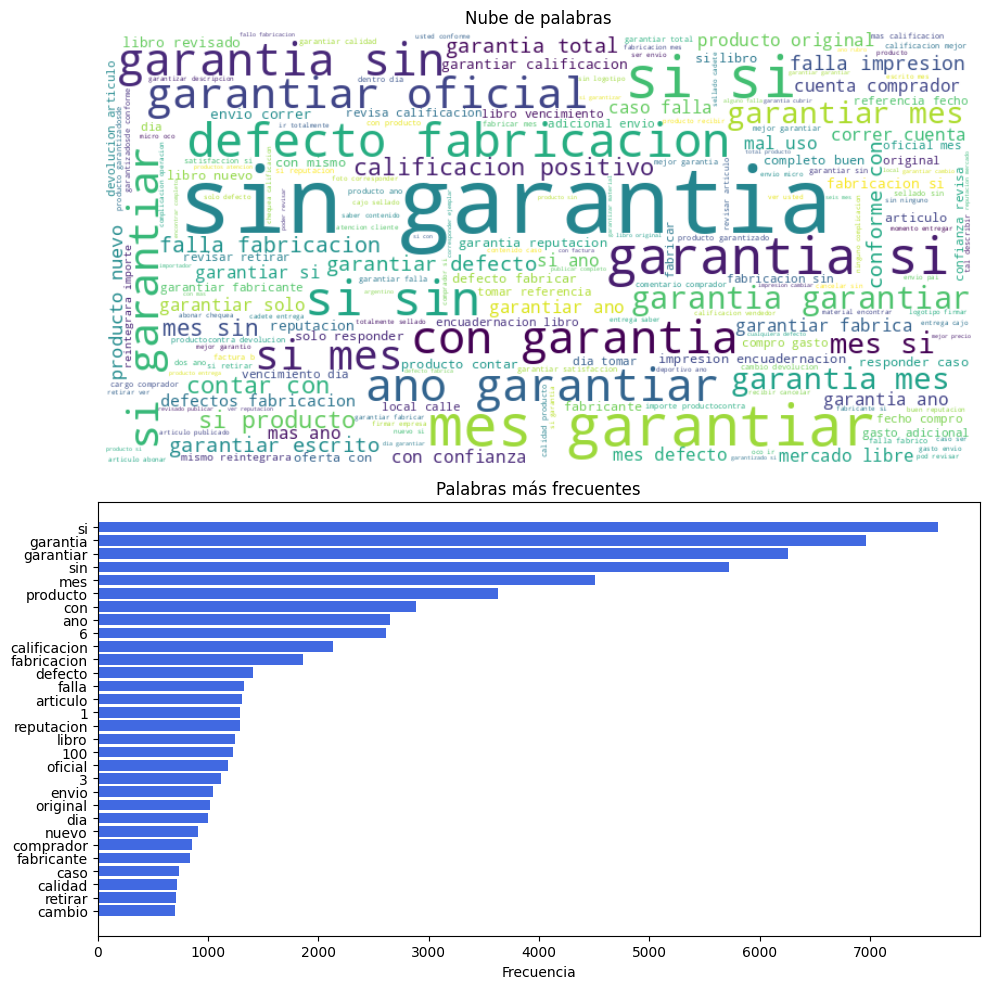

CPU times: user 3min 57s, sys: 2.84 s, total: 4min
Wall time: 4min 28s


In [ ]:
%%time
keep_words = ['sin', 'con']
df_temp = df_clean[df_clean['warranty'].notnull()] # Solo procesar la informacion con data
df_temp['warranty_clean'] = df_temp['warranty'].astype(str).map(
    lambda text: clean_text(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish', keep_words=keep_words))
wordcloud_custom(df_temp, 'warranty_clean')

In [ ]:
def top_value_counts(df, column, condition_col=None, condition_value=None, cumulative_threshold=100):
    """
    Genera una tabla con el conteo de valores únicos, porcentaje y porcentaje acumulado.

    Parámetros:
    - df: DataFrame a analizar.
    - column: Nombre de la columna a contar valores únicos.
    - condition_col: (Opcional) Nombre de la columna para filtrar datos.
    - condition_value: (Opcional) Valor de la condición a filtrar.
    - cumulative_threshold: (Opcional) Porcentaje acumulado máximo a mostrar.

    Retorna:
    - DataFrame con conteo, porcentaje y % acumulado.
    """
    if condition_col and condition_value is not None:
        df = df[df[condition_col] == condition_value]

    value_counts = df[column].value_counts().reset_index()
    value_counts.columns = [column, 'count']
    value_counts['percentage'] = (value_counts['count'] / value_counts['count'].sum()) * 100
    value_counts['cumulative_percentage'] = value_counts['percentage'].cumsum()

    # Filtrar por % acumulado
    value_counts = value_counts[value_counts['cumulative_percentage'] <= cumulative_threshold]

    return value_counts
# Obtener el top de 'warranty_clean' en productos nuevos y mostrar hasta 80% acumulado
top_value_counts(df_temp, 'warranty_clean', 'condition', 'new', 40)

,warranty_clean,count,percentage,cumulative_percentage
0,si,2992,13.676464,13.676464
1,sin garantia,1704,7.789002,21.465466
2,6 mes,1036,4.735567,26.201033
3,3 mes,389,1.778123,27.979156
4,1 ano,296,1.353019,29.332175
5,12 mes,253,1.156466,30.488641
6,3 mes garantiar,205,0.937057,31.425698
7,6 mes garantiar,194,0.886776,32.312474
8,fabricante,186,0.850208,33.162682
9,fabricar,181,0.827353,33.990035


In [ ]:
top_value_counts(df_temp, 'warranty_clean', 'condition', 'used', 65)

,warranty_clean,count,percentage,cumulative_percentage
0,si,3457,25.864133,25.864133
1,sin garantia,3221,24.098459,49.962592
2,reputacion,306,2.289391,52.251983
3,calificacion,240,1.795601,54.047583
4,oferta con confianza revisa calificacion,165,1.234476,55.282059
5,producto 100 garantizadosde conforme con mismo...,132,0.987580,56.269639
6,garantizar descripcion,116,0.867874,57.137513
7,con garantia,99,0.740685,57.878198
8,garantiar calificacion,91,0.680832,58.559030
9,pod revisar articulo abonar chequea calificaci...,90,0.673350,59.232381


In [ ]:
%%time
def classify_warranty(text, **kwargs):
    """Clasifica la descripción de garantía en una de las cinco categorías predefinidas."""

    # Normalización del texto
    text = clean_text(text, **kwargs)

    # Clasificación basada en reglas
    if re.search(r"\b(sin garantia|no tiene garantia|no ofrecemos|experiencia)\b", text):
        return "sin garantia"
    elif re.search(r"\b(reputacion|calificacion|calificaciones|comprador|venta|comentario|prueba)\b", text):
        return "garantia basada en reputacion"
    elif re.search(r"\b(con garantia|defectos de fabricacion|fallo|garantia por defectos|cubre defectos|si|garantia fabrica)\b", text):
        return "garantia por defectos"
    elif re.search(r"\b(mes|10 dia|30 dia|90 dia)\b", text):
        return "garantia media"
    elif re.search(r"\b(12 mes|1 ano|2 ano|3 ano|5 ano|garantia de por vida)\b", text):
        return "garantia larga"

    # Si no se clasifica en ninguna categoría, asignar "sin garantía"
    return "sin garantia"

# Aplicar la función al dataset
df_temp["warranty_class"] = df_temp["warranty"].apply(
    lambda text: classify_warranty(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish', keep_words=keep_words)
)
df_temp[['warranty',	'warranty_clean',	'warranty_class']].head(10)

CPU times: user 3min 47s, sys: 2.69 s, total: 3min 50s
Wall time: 3min 57s


<timed exec>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,warranty,warranty_clean,warranty_class
1,NUESTRA REPUTACION,reputacion,garantia basada en reputacion
4,MI REPUTACION.,reputacion,garantia basada en reputacion
5,Sí,si,garantia por defectos
8,1 Ano,1 ano,garantia larga
12,VACIOS sin utilizar,vacio sin utilizar,sin garantia
16,Se ve en el dia de la compra,ver dia compra,sin garantia
20,100% de acuerdo a descripcion e imagenes.,100 acuerdo descripcion imagenes,sin garantia
26,Sí. Librería a la calle.,si librerio calle,garantia por defectos
27,Sí,si,garantia por defectos
30,Mis calificaciones,calificacion,garantia basada en reputacion


In [ ]:
df_clean = df_clean.merge(df_temp[['index', 'warranty_class']], on='index', how='left').drop(columns='warranty')
df_clean['have_warranty'] = np.where(df_clean['warranty_class'].isin([np.nan, 'sin garantia']), 0, 1)

print(df_clean['warranty_class'].value_counts())
del df_temp;gc.collect()

warranty_class
sin garantia                     16420
garantia por defectos             8805
garantia basada en reputacion     4268
garantia media                    4261
garantia larga                    1489
Name: count, dtype: int64


1167552

In [ ]:
print(df_clean['have_warranty'].value_counts())

have_warranty
0    71177
1    18823
Name: count, dtype: int64


#### 2 - VAR: **shipping_methods**
**Discovery:**

* Missing (%): 3.0% datos faltantes
* Distinct values: 1 valor único lista vacía '[]'

**Meaning:**<br/>
podria representar los métodos de envío disponibles para el producto

**Key questions:**<br/>
NA

**Next steps:**<br/>
No se tiene en cuenta esta variable ya que todos los valores son listas vacias

In [ ]:
df_clean['shipping_methods'].value_counts()

,count
shipping_methods,
[],87310


In [ ]:
df_clean.drop(columns='shipping_methods', inplace=True)

#### 3 - VAR: 'non_mercado_pago_payment_methods_description' 'non_mercado_pago_payment_methods_id', 'non_mercado_pago_payment_methods_type'
**Discovery:**

* Missing (%): 30.6% datos faltantes (las 3 variables)
* Distinct values: 9 valores diferentes (non_mercado_pago_payment_methods_description)
* Distinct values: 3 valores diferentes (non_mercado_pago_payment_methods_type)

**Meaning:**<br/>
Describe los métodos de pago de los articulos. Los valores más frecuentes son Efectivo (predominante), 'Acordar con el comprador', 'MercadoPago', 'Transferencia bancaria' y 'American Express'. en el caso de description y toma valores de 'G', 'C' Y 'N' para la variable type

**Key questions:**<br/>
 ¿Los productos usados tienen más probabilidades de aceptar pagos fuera de Mercado Pago?

**Next steps:**<br/>
debido a la mayor cantidad de participaciòn de la opcion 'efectivo' podria ageupar las demàs en 'otros'. La variable 'non_mercado_pago_payment_methods_id' se descarta ya que tiene la misma información representada por etiquetas

In [ ]:
df_clean[['non_mercado_pago_payment_methods_description', 'non_mercado_pago_payment_methods_id', 'non_mercado_pago_payment_methods_type']].value_counts()

,,,count
non_mercado_pago_payment_methods_description,non_mercado_pago_payment_methods_id,non_mercado_pago_payment_methods_type,
Efectivo,MLAMO,G,59172
Acordar con el comprador,MLAWC,G,1032
MercadoPago,MLAMP,G,646
Transferencia bancaria,MLATB,G,574
American Express,MLAAM,C,533
Tarjeta de crédito,MLAOT,N,497
Giro postal,MLAWT,G,12
Contra reembolso,MLACD,G,2
Visa,MLAVS,C,1


In [ ]:
df_clean.drop(columns='non_mercado_pago_payment_methods_id', inplace=True)

#### 4 - VAR: 'attributes_value_id', 'attributes_attribute_group_id', 'attributes_name', 'attributes_value_name', 'attributes_attribute_group_name', 'attributes_id'
**Discovery:**<br/>
Missing (%): 87.6% (en todas las variables).

Distinct values:
* attributes_value_id: 146 valores.
* attributes_attribute_group_id: 5 valores.
* attributes_name: 23 valores.
* attributes_value_name: 1372 valores.
* attributes_attribute_group_name: 7 valores.
* attributes_id: 38 valores.

**Meaning:**<br/>
Todas las variables están relacionadas con los atributos de los productos, como nombres, valores, grupos e identificadores.

**Key questions:**<br/>
¿Es posible utilizar alguna de estas variables a pesar del alto porcentaje de datos faltantes?

**Next steps:**<br/>
No se consideran estas variables en el análisis debido a la alta cantidad de datos faltantes (87.6%) y su redundancia entre sí. En su lugar, se recomienda enfocarse en variables con menor cantidad de datos faltantes y mayor potencial predictivo para el modelo.

In [ ]:
df_clean[['attributes_attribute_group_id', 'attributes_attribute_group_name', 'attributes_name',
          'attributes_id', 'attributes_value_id', 'attributes_value_name']].value_counts().head(60)

attributes_attribute_group_id  attributes_attribute_group_name  attributes_name             attributes_id       attributes_value_id                      attributes_value_name
FIND                           Ficha técnica                    Season                      Season              Season-All-Season                        All-Season               2634
                                                                                                                Season-Autumn-Winter                     Autumn-Winter            1425
DFLT                           Otros                            Season                      Season              Season-All-Season                        All-Season               1362
FIND                           Ficha técnica                    Season                      Season              Season-Spring-Summer                     Spring-Summer             657
DFLT                           Otros                            Season                      Season              Season-Autumn-Winter                     Autumn-Winter             617
SONIDO                         Sonido                           Entrada USB                 MLA1744-USB         MLA1744-USB-N                            No                        550
DFLT                           Otros                            Número de pieza             PART_NUMBER                                                                            484
SONIDO                         Sonido                           Entrada USB                 MLA1744-USB         MLA1744-USB-Y                            Sí                        254
DFLT                           Otros                            Género                      GENDER              female                                   Mujer                     188
                                                                Season                      Season              Season-Spring-Summer                     Spring-Summer             183
                                                                Número pieza                MLA-PART_NUMBER                                                                        134
                                                                Género                      GENDER              male                                     Hombre                    110
                                                                Número de Pieza             MLA-14071407                                                                            47
                                                                Unidad de Referencia        MLA-UNIT_REFERENCE  611eef5                                  m2                         45
FIND                           Ficha técnica                    Año                         MLA1763-YEAR        fa5c825                                  2015                       44
                                                                                                                MLA1763-YEAR-2014                        2014                       42
DFLT                           Otros                            Ancho                       MLA_RIM_WIDTH                                                                           37
SONIDO                         Sonido                           MP3                         MLA58254-MP3        MLA58254-MP3-N                           No                         31
FIND                           Ficha técnica                    Año                         MLA1763-YEAR        MLA1763-YEAR-2013                        2013                       26
SECURITY                       Seguridad                        Faros antinieblas traseros  MLA1745-NEBLTRAS    MLA1745-NEBLTRAS-N                       No                         19
FIND                           Ficha técnica                    Superficie total (m²)       MLA1472-MTRSTOTAL                                            60          

In [ ]:
df_clean.drop(columns=['attributes_attribute_group_id', 'attributes_attribute_group_name', 'attributes_name',
          'attributes_id', 'attributes_value_id', 'attributes_value_name'], inplace=True)

#### 5 - VAR: tags_0
**Discovery:**<br/>
* Missing (%): 24.9% datos faltantes
* Distinct values: 4 valores diferentes

**Meaning:**<br/>
Representa etiquetas asociadas a la visibilidad y calidad de las publicaciones. dragged_bids_and_visits sugiere que el producto ha generado interacciones sin concretar ventas, dragged_visits indica solo visualizaciones sin ofertas, good_quality_thumbnail implica imágenes atractivas, y poor_quality_thumbnail refleja problemas en la calidad visual del producto.

**Key questions:**<br/>
¿Los productos con etiquetas de baja calidad de imagen 'poor_quality_thumbnail o pocas interacciones 'dragged_visits' tienen mayor probabilidad de ser usados?

**Next steps:**<br/>
Analizar la relación entre tags_0 y la condición del producto nuevo/usado. Evaluar la posibilidad de agrupar etiquetas similares o transformarlas en una variable ordinal basada en calidad e interacción

In [ ]:
df_clean['tags_0'].value_counts()

,count
tags_0,
dragged_bids_and_visits,65315
good_quality_thumbnail,1537
dragged_visits,723
poor_quality_thumbnail,13


#### 6 - VAR: parent_item_id
**Discovery:**<br/>
* Missing (%): 23% datos faltantes
* Distinct values: 69.3k valores diferentes

**Meaning:**<br/>
representa un identificador único para cada producto. como se tienen 90k de registros quiere decir que diferentes productos pueden tener el mismo parend_id

**Key questions:**<br/>
NA

**Next steps:**<br/>
No se considera esta variable en el análisis debido a su naturaleza de identificador

In [ ]:
df_clean['parent_item_id'].value_counts()

,count
parent_item_id,
MLA6553902747,1
MLA4317323376,1
MLA3842402942,1
MLA6950118955,1
MLA2431639060,1
...,...
MLA2301627608,1
MLA5909068300,1
MLA7790783866,1


In [ ]:
df_clean.drop(columns='parent_item_id', inplace=True)

#### 7 - VAR: descriptions_0
**Discovery:**<br/>
* Missing (%): 2.7% datos faltantes
* Distinct values: 87.5k valores diferentes

**Meaning:**<br/>
Parece un id unico dentro de 'Mercado Libre Argentina' MLA respecto a un id difernte

**Key questions:**<br/>
NA

**Next steps:**<br/>
No se considera esta variable en el análisis debido a su naturaleza de identificador

In [ ]:
df_clean['descriptions_0'].value_counts()

,count
descriptions_0,
{'id': 'MLA4695330653-912855983'},1
{'id': 'MLA4646842037-913168881'},1
{'id': 'MLA6222251364-917350062'},1
{'id': 'MLA3184179382-900555397'},1
{'id': 'MLA5890602855-936034485'},1
...,...
{'id': 'MLA6410600844-935154349'},1
{'id': 'MLA8932773648-931701858'},1
{'id': 'MLA7808141514-938090620'},1


In [ ]:
df_clean.drop(columns='descriptions_0', inplace=True)

#### 8 - VAR: 'pictures_size', 'pictures_secure_url', 'pictures_max_size', 'pictures_url', 'pictures_quality', 'pictures_id'
**Discovery:**<br/>
* Missing (%): 0.8% datos faltantes (en todas las variables).

Distinct values:
* pictures_size: 7,5k valores.
* pictures_secure_url: 89,2k valores.
* pictures_max_size: 17,4k valores.
* pictures_url: 89,2k valores.
* pictures_quality: 1 valor.
* pictures_id: 89,2k valores.

**Meaning:**<br/>
Todas las variables están relacionadas con las imágenes de los productos, incluyendo su tamaño, URL, calidad e identificador único.

**Key questions:**<br/>
¿Pueden las características de las imágenes aportar información relevante para distinguir productos nuevos/usados?

**Next steps:**<br/>
Solo se tiene en cuenta las variables relacionadas al tamaño de la imagen, ya que se puede ver si el tamaño de la imagen esta relacionado a si el producto es nuevo/usado. extraer los valores de ancho y alto de cada imagen y generar area y ratio relation. Las demás variables como los links (no tenemos acceso) y la constante (pictures_quality) como los id no los tendremos en cuenta

Relación de aspecto	Posible origen
1:1 (1.0)	Fotos cuadradas, típicas de tiendas oficiales.
4:3 (1.33)	Común en cámaras digitales y algunas fotos de smartphones.
16:9 (1.78)	Usado en pantallas y algunas fotos de smartphones en modo paisaje.
3:2 (1.5)	Más común en cámaras profesionales.

In [ ]:
df_clean[['pictures_size', 'pictures_secure_url', 'pictures_max_size', 'pictures_url', 'pictures_quality', 'pictures_id']].value_counts()

pictures_size  pictures_secure_url                                                                pictures_max_size  pictures_url                                                    pictures_quality  pictures_id                
250x250        https://a248.e.akamai.net/mla-s1-p.mlstatic.com/6279-MLApp_27_21489919_1-O.jpg     250x250            http://mla-s1-p.mlstatic.com/6279-MLApp_27_21489919_1-O.jpg                       6279-MLApp_27_21489919_1       4
               https://a248.e.akamai.net/mla-s1-p.mlstatic.com/6270-MLApp_27_19602074_1-O.jpg     250x250            http://mla-s1-p.mlstatic.com/6270-MLApp_27_19602074_1-O.jpg                       6270-MLApp_27_19602074_1       2
100x100        https://a248.e.akamai.net/mla-s1-p.mlstatic.com/135201-MLA6454277213_052015-O.jpg  100x100            http://mla-s1-p.mlstatic.com/135201-MLA6454277213_052015-O.jpg                    135201-MLA6454277213_052015    1
500x375        https://a248.e.akamai.net/mla-s1-p.mlstatic.com/13690-MLA5150984428_774-O.jpg      1200x900           http://mla-s1-p.mlstatic.com/13690-MLA5150984428_774-O.jpg                        13690-MLA5150984428_774        1
               https://a248.e.akamai.net/mla-s1-p.mlstatic.com/13692-MLA9742287265_102012-O.jpg   1200x900           http://mla-s1-p.mlstatic.com/13692-MLA9742287265_102012-O.jpg                     13692-MLA9742287265_102012     1
                                                                                                                                                                                                                                     ..
375x500        https://a248.e.akamai.net/mla-s2-p.mlstatic.com/15177-MLA8958468906_052014-O.jpg   900x1200           http://mla-s2-p.mlstatic.com/15177-MLA8958468906_052014-O.jpg                     15177-MLA8958468906_052014     1
               https://a248.e.akamai.net/mla-s2-p.mlstatic.com/15176-MLA1759122326_052014-O.jpg   900x1200           http://mla-s2-p.mlstatic.com/15176-MLA1759122326_052014-O.jpg                     15176-MLA1759122326_052014     1
               https://a248.e.akamai.net/mla-s2-p.mlstatic.com/15171-MLA9888703161_052014-O.jpg   900x1200           http://mla-s2-p.mlstatic.com/15171-MLA9888703161_052014-O.jpg                     15171-MLA9888703161_052014     1
               https://a248.e.akamai.net/mla-s2-p.mlstatic.com/15155-MLA2669212056_052014-O.jpg   900x1200           http://mla-s2-p.mlstatic.com/15155-MLA2669212056_052014-O.jpg                     15155-MLA2669212056_052014     1
99x99          https://a248.e.akamai.net/mla-s2-p.mlstatic.com/8452-MLA5333917432_112013-O.jpg    99x99              http://mla-s2-p.mlstatic.com/8452-MLA5333917432_112013-O.jpg                      8452-MLA5333917432_112013      1
Name: count, Length: 89293, dtype: int64

In [ ]:
def extract_dimensions(size):
    """Extrae el ancho y alto de una cadena con formato 'AnchoxAlto'."""
    if isinstance(size, str) and 'x' in size:
        width, height = map(int, size.split('x'))
        return width, height
    return None, None

# alto y ancho de cada imagen
df_clean[['pictures_width', 'pictures_height']] = df_clean['pictures_size'].apply(lambda x: pd.Series(extract_dimensions(x)))
df_clean[['pictures_max_width', 'pictures_max_height']] = df_clean['pictures_max_size'].apply(lambda x: pd.Series(extract_dimensions(x)))

# area de cada imagen
df_clean['pictures_area'] = df_clean['pictures_width'] * df_clean['pictures_height']
df_clean['pictures_max_area'] = df_clean['pictures_max_width'] * df_clean['pictures_max_height']

# ratio relation
df_clean['pictures_ratio_relation'] = df_clean['pictures_width'] / df_clean['pictures_height']
df_clean['pictures_max_ratio_relation'] = df_clean['pictures_max_width'] / df_clean['pictures_max_height']

df_clean[['pictures_size', 'pictures_width', 'pictures_height', 'pictures_area', 'pictures_ratio_relation']].head(10)

,pictures_size,pictures_width,pictures_height,pictures_area,pictures_ratio_relation
0,500x375,500.0,375.0,187500.0,1.333333
1,500x326,500.0,326.0,163000.0,1.533742
2,375x500,375.0,500.0,187500.0,0.750000
3,500x372,500.0,372.0,186000.0,1.344086
4,375x500,375.0,500.0,187500.0,0.750000
5,250x250,250.0,250.0,62500.0,1.000000
6,500x375,500.0,375.0,187500.0,1.333333
7,500x375,500.0,375.0,187500.0,1.333333
8,500x500,500.0,500.0,250000.0,1.000000
9,375x500,375.0,500.0,187500.0,0.750000


In [ ]:
df_clean.drop(columns=['pictures_size', 'pictures_secure_url', 'pictures_max_size', 'pictures_url', 'pictures_quality', 'pictures_id'], inplace=True)

### 5.4 Evaluar las variables restantes para determinar su impacto en el modelo.

In [ ]:
other_cols = list(set(cols_other) - set(cols_high_null) - set(cols_constant) - set(unsupported_cols))
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['thumbnail', 'shipping_free_shipping', 'start_time', 'buying_mode', '0', 'last_updated', 'automatic_relist', 'status', 'shipping_tags', 'seller_id', 'shipping_mode', 'condition', 'seller_address_state.name', 'date_created', 'shipping_local_pick_up', 'category_id', 'initial_quantity', 'seller_address_country.name', 'secure_thumbnail', 'sold_quantity', 'title', 'base_price', 'currency_id', 'available_quantity', 'index', 'price', 'stop_time', 'listing_type_id', 'seller_address_city.name', 'accepts_mercadopago']


#### 1 - VAR: 'base_price', 'price'
**Discovery:**<br/>
Missing (%): 0.0% (en todas las variables).

Distinct values:
* base_price: 9,5k valores.
* price: 9,5k valores.

**Meaning:**<br/>
Las variables representan el precio base del producto (base_price) y el precio final (price). Ambas variables tienen una distribución sesgada y alta correlación entre sí. No presentan valores nulos, negativos ni infinitos.

**Key questions:**<br/>
¿Es necesario transformar estas variables para reducir su sesgo?
¿La diferencia entre base_price y price puede aportar información relevante sobre descuentos o estrategias de precios?

**Next steps:**<br/>
aplicar transformaciones si es necesario como logaritmo o normalización. También, explorar la diferencia entre base_price y price como una posible variable

In [ ]:
df_clean[['price', 'base_price']]

,price,base_price
0,80.00,80.00
1,2650.00,2650.00
2,60.00,60.00
3,580.00,580.00
4,30.00,30.00
...,...,...
89995,68.00,68.00
89996,126.00,126.00
89997,300.00,300.00
89998,696.58,696.58


In [ ]:
df_clean['diff_price'] = df_clean['price'] - df_clean['base_price']

In [ ]:
other_cols.remove('price')
other_cols.remove('base_price')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['thumbnail', 'shipping_free_shipping', 'start_time', 'buying_mode', '0', 'last_updated', 'automatic_relist', 'status', 'shipping_tags', 'seller_id', 'shipping_mode', 'condition', 'seller_address_state.name', 'date_created', 'shipping_local_pick_up', 'category_id', 'initial_quantity', 'seller_address_country.name', 'secure_thumbnail', 'sold_quantity', 'title', 'currency_id', 'available_quantity', 'index', 'stop_time', 'listing_type_id', 'seller_address_city.name', 'accepts_mercadopago']


#### 2 - VAR: 'initial_quantity', 'sold_quantity', 'available_quantity'
**Discovery:**<br/>
Missing (%): 0.0% (en todas las variables).

Distinct values:
* sold_quantity: 304 valores.
* available_quantity: 441 valores.
* initial_quantity: 425 valores.

**Meaning:**<br/>
Las variables representan la cantidad de productos vendidos 'sold_quantity', la cantidad disponible 'available_quantity' y la cantidad inicial en stock 'initial_quantity'. sold_quantity muestra una distribución altamente sesgada con una gran cantidad de ceros aprox 83%, mientras que available_quantity e initial_quantity no presentan ceros ni valores negativos.

**Key questions:**<br/>
¿Es relevante la cantidad de productos vendidos para predecir si un producto es nuevo o usado?
¿Se puede derivar una nueva variable que relacione sold_quantity, available_quantity e initial_quantity para obtener información sobre la demanda y disponibilidad del producto?

**Next steps:**<br/>
Se recomienda analizar la proporción de productos vendidos respecto a la cantidad inicial para detectar patrones de demanda. También, considerar transformar sold_quantity debido a su alta cantidad de ceros y distribución sesgada.

In [ ]:
df_clean[['title', 'initial_quantity', 'sold_quantity', 'available_quantity']].tail(10)

,title,initial_quantity,sold_quantity,available_quantity
89990,Cuerpo&mente En Deportes,1,0,1
89991,Excelentes Zuecos !!! Imperdibles!!!!,1,0,1
89992,Academia Nacional De Bellas Artes 1878 1928 Ci...,1,0,1
89993,Bateria 12n5-3b Yamaha Ybr 125 C.c! En Wagner ...,10,0,10
89994,Mini Vestido/remera De Pailets Super Cool- Imp...,1,0,1
89995,El Fin De Las Libertades - Benegas Lynch (h) -...,1,0,1
89996,Honda Wave Guardabarro Interior Trasero,1,1,1
89997,My Little Pony Completa Latino 4 Temporadas,1,0,1
89998,Accidente Cerebrovascular En La Infancia Y Ado...,100,0,100
89999,Campera De Mujer Tucci Reversible,1,0,1


In [ ]:
other_cols.remove('initial_quantity')
other_cols.remove('sold_quantity')
other_cols.remove('available_quantity')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['thumbnail', 'shipping_free_shipping', 'start_time', 'buying_mode', '0', 'last_updated', 'automatic_relist', 'status', 'shipping_tags', 'seller_id', 'shipping_mode', 'condition', 'seller_address_state.name', 'date_created', 'shipping_local_pick_up', 'category_id', 'seller_address_country.name', 'secure_thumbnail', 'title', 'currency_id', 'index', 'stop_time', 'listing_type_id', 'seller_address_city.name', 'accepts_mercadopago']


#### 3 - VAR: 'shipping_tags', 'shipping_local_pick_up', 'shipping_free_shipping', 'shipping_mode'
**Discovery:**<br/>
Missing (%): 0.0% (en todas las variables).

Distinct values:
* shipping_free_shipping: 2 valores True/False.
* shipping_mode: 4 valores me2/not_specified/custom/me1
* shipping_local_pick_up: 2 valores True/False
* shipping_tags: no se tiene en cuenta por la cantidad de valores erroneos 99.9%

**Meaning:**<br/>
Las variables representan el tipo de entrega del producto, si se realiza envio gratis o no, si se permite retiro en punto de venta y el método de envio

**Key questions:**<br/>
¿Los productos con envío gratuito tienen más probabilidades de ser nuevos?
¿Ciertos métodos de envío están más asociados con productos usados?
¿La opción de recogida local es más común en productos usados que en nuevos?

**Next steps:**<br/>
Analizar el comportamiento de estas variables respecto a la condicion nuevo/usado para contemplar una posible transformación y evitar correlación entre las mismas

In [ ]:
df_clean['shipping_tags'].value_counts()

,count
shipping_tags,
[],89941
[relisted_with_modifications],50
[free_method_upgraded],9


In [ ]:
df_clean.drop(columns='shipping_tags', inplace=True)
other_cols.remove('shipping_tags')
other_cols.remove('shipping_local_pick_up')
other_cols.remove('shipping_free_shipping')
other_cols.remove('shipping_mode')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['buying_mode', '0', 'automatic_relist', 'status', 'condition', 'category_id', 'title', 'currency_id', 'index', 'listing_type_id', 'accepts_mercadopago']


#### 4 - VAR: 'stop_time', 'date_created', 'last_updated', 'start_time'
**Discovery:**<BR/>
Missing (%): 0.0% (en todas las variables).

Distinct values:

* last_updated: 86,015 valores distintos.
* start_time: 78,890 valores distintos.
* stop_time: 78,486 valores distintos.
* date_created: 79,247 valores distintos.

**Meaning:**<BR/>
Estas variables están relacionadas con la actividad temporal de las publicaciones en la plataforma, date_created puede representar la fecha en la que se creó originalmente la publicación. last_updated puede indicar la última fecha en la que se actualizó la publicación. start_time es el momento en el que la publicación se activó (vamos a revisar si es diferentes a la hora de la creación). stop_time puede ser cuándo expiró o fue dada de baja.

**Key questions:**<BR/>
¿La antigüedad de una publicación influye en la probabilidad de que el producto sea nuevo o usado?
¿Las publicaciones más recientes tienen mayor probabilidad de contener productos nuevos?
¿El tiempo entre date_created y start_time afecta la categorización del producto como nuevo o usado?

**Next steps:**<BR/>
Vamos a crear la diferencia entre 'date_created y start_time', la duración total de la publicación 'stop_time - start_time' y el tiempo desde la última actualización 'last_updated - date_created'

In [ ]:
df_clean[['start_time', 'last_updated', 'date_created', 'stop_time']]

,start_time,last_updated,date_created,stop_time
0,1441485773000,2015-09-05T20:42:58.000Z,2015-09-05T20:42:53.000Z,1446669773000
1,1443290910000,2015-09-26T18:08:34.000Z,2015-09-26T18:08:30.000Z,1448474910000
2,1441843027000,2015-09-09T23:57:10.000Z,2015-09-09T23:57:07.000Z,1447027027000
3,1443466076000,2015-10-05T16:03:50.306Z,2015-09-28T18:47:56.000Z,1449191596000
4,1440454040000,2015-08-28T13:37:41.000Z,2015-08-24T22:07:20.000Z,1445638040000
...,...,...,...,...
89995,1443793010000,2015-10-02T13:36:51.000Z,2015-10-02T13:36:50.000Z,1448977010000
89996,1442964621000,2015-10-05T17:45:04.000Z,2015-09-22T23:30:21.000Z,1448148621000
89997,1440452031000,2015-08-24T21:33:54.000Z,2015-08-24T21:33:51.000Z,1445636031000
89998,1443813656000,2015-10-02T19:21:05.000Z,2015-10-02T19:20:56.000Z,1448997656000


In [ ]:
# Convert relevant columns to datetime objects
for col in ['last_updated', 'date_created']:
    try:
        df_clean[col] = pd.to_datetime(df_clean[col], utc=True)
    except ValueError:
        # Handle cases where conversion fails (e.g., invalid date formats)
        print(f"Could not convert column '{col}' to datetime.  Check for invalid date formats.")
        # Option 1:  Remove rows with bad data:
        df_clean = df_clean[pd.to_datetime(df_clean[col], errors='coerce').notna()]

        # Option 2: Fill with a default date (e.g. the epoch):
        # df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce').fillna(pd.Timestamp('1970-01-01'))

df_clean['start_time'] = pd.to_datetime(df_clean['start_time'], unit='ms', utc=True)
df_clean['stop_time'] = pd.to_datetime(df_clean['stop_time'], unit='ms', utc=True)

In [ ]:
# Calculate time differences
df_clean['time_to_start'] = (df_clean['start_time'] - df_clean['date_created']).dt.total_seconds() / 86400  # Dias
df_clean['listing_duration'] = (df_clean['stop_time'] - df_clean['start_time']).dt.total_seconds() / 86400  # Dias
df_clean['time_since_last_update'] = (df_clean['last_updated'] - df_clean['date_created']).dt.total_seconds() / 86400  # Dias

df_clean[['start_time', 'last_updated', 'date_created', 'stop_time', 'time_to_start', 'listing_duration', 'time_since_last_update']]

,start_time,last_updated,date_created,stop_time,time_to_start,listing_duration,time_since_last_update
0,2015-09-05 20:42:53+00:00,2015-09-05 20:42:58+00:00,2015-09-05 20:42:53+00:00,2015-11-04 20:42:53+00:00,0.0,60.000000,0.000058
1,2015-09-26 18:08:30+00:00,2015-09-26 18:08:34+00:00,2015-09-26 18:08:30+00:00,2015-11-25 18:08:30+00:00,0.0,60.000000,0.000046
2,2015-09-09 23:57:07+00:00,2015-09-09 23:57:10+00:00,2015-09-09 23:57:07+00:00,2015-11-08 23:57:07+00:00,0.0,60.000000,0.000035
3,2015-09-28 18:47:56+00:00,2015-10-05 16:03:50.306000+00:00,2015-09-28 18:47:56+00:00,2015-12-04 01:13:16+00:00,0.0,66.267593,6.886045
4,2015-08-24 22:07:20+00:00,2015-08-28 13:37:41+00:00,2015-08-24 22:07:20+00:00,2015-10-23 22:07:20+00:00,0.0,60.000000,3.646076
...,...,...,...,...,...,...,...
89995,2015-10-02 13:36:50+00:00,2015-10-02 13:36:51+00:00,2015-10-02 13:36:50+00:00,2015-12-01 13:36:50+00:00,0.0,60.000000,0.000012
89996,2015-09-22 23:30:21+00:00,2015-10-05 17:45:04+00:00,2015-09-22 23:30:21+00:00,2015-11-21 23:30:21+00:00,0.0,60.000000,12.760220
89997,2015-08-24 21:33:51+00:00,2015-08-24 21:33:54+00:00,2015-08-24 21:33:51+00:00,2015-10-23 21:33:51+00:00,0.0,60.000000,0.000035
89998,2015-10-02 19:20:56+00:00,2015-10-02 19:21:05+00:00,2015-10-02 19:20:56+00:00,2015-12-01 19:20:56+00:00,0.0,60.000000,0.000104


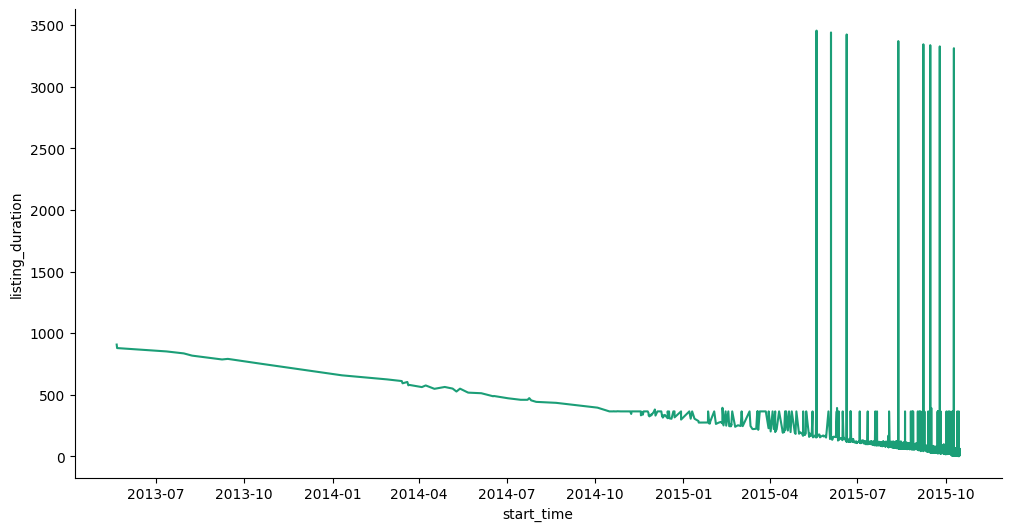

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['start_time']
  ys = series['listing_duration']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_clean.sort_values('start_time', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('start_time')
_ = plt.ylabel('listing_duration')

In [ ]:
df_clean.drop(columns=['start_time', 'last_updated', 'date_created', 'stop_time'], inplace=True)
other_cols.remove('start_time')
other_cols.remove('last_updated')
other_cols.remove('date_created')
other_cols.remove('stop_time')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['thumbnail', 'shipping_free_shipping', 'buying_mode', '0', 'automatic_relist', 'status', 'shipping_tags', 'seller_id', 'shipping_mode', 'condition', 'seller_address_state.name', 'shipping_local_pick_up', 'category_id', 'seller_address_country.name', 'secure_thumbnail', 'title', 'currency_id', 'index', 'listing_type_id', 'seller_address_city.name', 'accepts_mercadopago']


#### 5 - VAR: 'thumbnail', 'secure_thumbnail'
**Discovery:**<BR/>
Missing (%): 0.0% (en todas las variables).

Distinct values:

* thumbnail: 99.2% valores distintos.
* secure_thumbnail: 99.2% valores distintos.

**Meaning:**<BR/>
representan enlaces a posibles imágenes de productos. sin embargo al probar los enlaces no nos deja ingresar. puede ser normal ya que esas imagenes pueden estar almacenadas en aplicativos con control de acceso

**Key questions:**<BR/>
NA

**Next steps:**<BR/>
No se tienen en cuenta estas variables ya que no podemos acceder a las ubicaciones de las imagenes

In [ ]:
df_clean[['thumbnail', 'secure_thumbnail']]

,thumbnail,secure_thumbnail
0,http://mla-s1-p.mlstatic.com/5386-MLA469533065...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...
1,http://mla-s1-p.mlstatic.com/23223-MLA71604471...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...
2,http://mla-s1-p.mlstatic.com/22076-MLA73671899...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...
3,http://mla-s2-p.mlstatic.com/183901-MLA9191625...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...
4,http://mla-s2-p.mlstatic.com/13595-MLA77879618...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...
...,...,...
89995,http://mla-s2-p.mlstatic.com/13612-MLA13155203...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...
89996,http://mla-s1-p.mlstatic.com/15240-MLA69343770...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...
89997,http://mla-s1-p.mlstatic.com/600001-MLA5644559...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...
89998,http://mla-s2-p.mlstatic.com/4664-MLA352024407...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...


In [ ]:
df_clean.drop(columns=['thumbnail', 'secure_thumbnail'], inplace=True)
other_cols.remove('thumbnail')
other_cols.remove('secure_thumbnail')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['shipping_free_shipping', 'buying_mode', '0', 'automatic_relist', 'status', 'shipping_tags', 'seller_id', 'shipping_mode', 'condition', 'seller_address_state.name', 'shipping_local_pick_up', 'category_id', 'seller_address_country.name', 'title', 'currency_id', 'index', 'listing_type_id', 'seller_address_city.name', 'accepts_mercadopago']


#### 6 - VAR: 'seller_id', 'seller_address_state.name', 'seller_address_country.name', 'seller_address_city.name'
**Discovery:**<br/>
Missing (%): 0.0% (en todas las variables).

Distinct values:
* seller_address_country.name: 2 valores distintos.
* seller_address_state.name: 25 valores distintos.
* seller_address_city.name: 3,480 valores distintos.
* seller_id: 33,281 valores distintos.

**Meaning:**<br/>
Describen la ubicación del usuario. seller_address_country.name muestra el país del vendedor, aunque el 99.9% de los valores corresponden a Argentina, por lo que su variabilidad es muy baja. seller_address_state.name indica la provincia dentro de Argentina, con una alta concentración en Capital Federal y Buenos Aires. seller_address_city.name brinda una granularidad mayor con miles de ciudades distintas. seller_id representa identificadores únicos de vendedores, lo que permite analizar su comportamiento y volumen de ventas.

**Key questions:**<br/>
¿Los vendedores de ciertas provincias tienen mayor proporción de productos nuevos o usados?
¿Existen vendedores que solo vendan productos nuevos o usados?
¿La ubicación del vendedor influye en la venta de productos usados o nuevos?

**Next steps:**<br/>
No se tienen en cuenta 'seller_address_country.name' ya que solo esta el pais Argentina y tampoco 'seller_id'debido a su alta cardinalidad. mantenemos state y city para ver la relación respecto a los productos nuevos/usados

In [ ]:
df_clean[['seller_id', 'seller_address_state.name', 'seller_address_country.name', 'seller_address_city.name']].value_counts()

,,,,count
seller_id,seller_address_state.name,seller_address_country.name,seller_address_city.name,
5248662274,Capital Federal,Argentina,Palermo,850
2015548469,Capital Federal,Argentina,Mataderos,654
7704929703,Capital Federal,Argentina,CABA,424
4631246902,Buenos Aires,Argentina,Bragado,408
8612126795,Capital Federal,Argentina,Caba,318
...,...,...,...,...
4494662588,Capital Federal,Argentina,capital federal,1
4494141507,Buenos Aires,Argentina,don torcuato,1
4494118993,Capital Federal,Argentina,Caballito,1


In [ ]:
df_clean.drop(columns=['seller_id', 'seller_address_country.name'], inplace=True)
other_cols.remove('seller_id')
other_cols.remove('seller_address_state.name')
other_cols.remove('seller_address_country.name')
other_cols.remove('seller_address_city.name')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['buying_mode', '0', 'automatic_relist', 'status', 'condition', 'category_id', 'title', 'currency_id', 'index', 'listing_type_id', 'accepts_mercadopago']


#### 7 - VAR: 'buying_mode'
**Discovery:**<br/>
Missing (%): 0.0%.

Distinct values:

buying_mode: 3 valores distintos 'buy_it_now, classified, auction'
Distribución:

* buy_it_now: 87,311 (96.9%).
* classified: 1,982 (2.2%).
* auction: 707 (0.8%).

**Meaning:**<br/>
La variable buying_mode indica el método de compra disponible en la plataforma. buy_it_now representa la opción de compra directa, que es la más común con un 96.9% de los casos. classified corresponde a publicaciones sin opción de compra directa, generalmente para productos con negociación previa. auction permite que los compradores pujen por el producto, aunque su uso es marginal '0.8%'.

**Key questions:**<br/>
¿Esta variable tiene información relevante para saber si un productoe s nuevo/usado?

**Next steps:**<br/>
analizar la relación con la condicion del producto para ver si es relevante en articulos nuevos/usados. posiblemente la deprequemos a futuro por su desbalance, sin mebargo, dejamos que esto lo realice la selección de variables solo para estar seguros

In [ ]:
other_cols.remove('buying_mode')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['0', 'automatic_relist', 'status', 'condition', 'category_id', 'title', 'currency_id', 'index', 'listing_type_id', 'accepts_mercadopago']


#### 8 - VAR: 'automatic_relist'
**Discovery:**<br/>
Missing (%): 0.0%.

Distinct values: 2 valores distintos (True, False). [95.5%, 4.5%]

**Meaning:**<br/>
puede indica si una publicación se vuelve a listar automáticamente después de su vencimiento o fecha limite. Un 95.5% de las publicaciones no se relistan automáticamente, mientras que un 4.5% si lo hacen

**Key questions:**<br/>
¿Los productos usados tienen mayor probabilidad de estar en publicaciones con automatic_relist = True?

**Next steps:**<br/>
Analizar la relación entre automatic_relist y la condición del producto nuevo/usado ya que al igual que la variable anterior maneja un fuerte desbalance

In [ ]:
other_cols.remove('automatic_relist')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['0', 'status', 'condition', 'category_id', 'title', 'currency_id', 'index', 'listing_type_id', 'accepts_mercadopago']


#### 9 - VAR: 'status'
**Discovery:**<br/>
Missing (%): 0.0%.

Distinct values: 4 valores distintos

active: 86,116 (95.7%).
paused: 3,863 (4.3%).
closed: 20 (<0.1%).
not_yet_active: 1 (<0.1%).

**Meaning:**<br/>
indica el estado actual de la publicación. La gran mayoría están activas, mientras que una pequeña proporción se encuentra pausada o cerrada. Solo una publicación está en estado not_yet_active, lo que sugiere que aún no ha sido activada.

**Key questions:**<br/>
¿Las publicaciones pausadas tienen más probabilidades de ser de productos usados?
¿El estado closed está asociado con productos usados que han sido vendidos o eliminados?

**Next steps:**<br/>
Analizar la relación entre status y la condición del producto.

In [ ]:
other_cols.remove('status')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['0', 'condition', 'category_id', 'title', 'currency_id', 'index', 'listing_type_id', 'accepts_mercadopago']


#### 10 - VAR: 'category_id', 'currency_id', '0'
**Discovery:**<br/>
Vemos que category_id puede representar el ID de la categoria

**Meaning:**<br/>
Estas variables no aportan información relevante al modelo y en muchos casos son variables auxiliares o casi constantes

**Key questions:**<br/>
NA

**Next steps:**<br/>
No se tienen en cuenta currency id

In [ ]:
df_clean.drop(columns=['category_id', '0'], inplace=True)
other_cols.remove('category_id')
other_cols.remove('currency_id')
other_cols.remove('0')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['condition', 'title', 'listing_type_id', 'accepts_mercadopago']


#### 11 - VAR: 'listing_type_id'
**Discovery:**<br/>
Missing (%): 0.0%.

Distinct values: 7 valores distintos.

**Meaning:**<br/>
Representa el tipo de publicación utilizada por el vendedor. La mayoría de las publicaciones pertenecen a las categorías bronze y free, lo que indica que la mayoría de los vendedores optan por opciones económicas o gratuitas. Los tipos gold, gold_special, gold_premium y gold_pro son menos frecuentes, lo que sugiere que podrían estar asociados con vendedores más grandes o estrategias de venta premium.

**Key questions:**<br/>
¿Existe una relación entre el tipo de publicación y la condición del producto nuevo/usado?
¿Los tipos de publicación más costosos (gold, gold_premium, gold_pro) están asociados con productos nuevos o vendedores con más ventas?

**Next steps:**<br/>
Analizar la relación entre listing_type_id y la condición del producto.
Evaluar si los tipos de publicación más costosos tienen mayor tiempo de actividad o mayor tasa de conversión

In [ ]:
df_clean['listing_type_id'].value_counts()

,count
listing_type_id,
bronze,56904
free,19260
silver,8195
gold_special,2693
gold,2170
gold_premium,765
gold_pro,13


In [ ]:
other_cols.remove('listing_type_id')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['condition', 'title', 'accepts_mercadopago']


#### VAR: 12 - 'accepts_mercadopago'
**Discovery:**<br/>
Missing (%): 0.0%.

Distinct values: 2 valores distintos

**Meaning:**<br/>
Indica si acepta mercado pago o no, similar a los metodos de pago

**Key questions:**<br/>
NA

**Next steps:**<br/>
Analizar la relación entre accepts_mercadopago y la condición del producto nuevo/usado ya que maneja un fuerte desbalance

In [ ]:
other_cols.remove('accepts_mercadopago')
print("Columnas faltantes:", other_cols)

Columnas faltantes: ['condition', 'title']


#### 13 - VAR: 'title'
**Discovery:**

* Missing (%): 60.8% datos faltantes
* Distinct values: 9.5k valores diferentes

**Meaning:**<br/>
La garantía del producto es descrita por los vendedores de manera no estandarizada, lo que dificulta su categorización directa. Este campo incluye desde frases descriptivas hasta términos específicos, generando una alta variabilidad en los valores.

**Key questions:**<br/>
¿Cómo influye la garantía en la decisión de compra?
¿Es posible agrupar los valores en categorías más manejables?

**Next steps:**<br/>
Normalizar el texto utilizando una función de limpieza que elimine caracteres especiales, stopwords y verificar si requiere o no aplicar lematización para simplificar el texto. Luego, identificar las palabras y frases más frecuentes que permitan clasificar las garantías en categorías predefinidas: ["garantía basada en reputación", "garantía por defectos", "garantía media", "garantía larga" o "sin garantía"]. Para los registros con valores faltantes, se asignará la etiqueta "desconocido", procesando únicamente los productos con información de garantia para ahorrar tiempo de computo

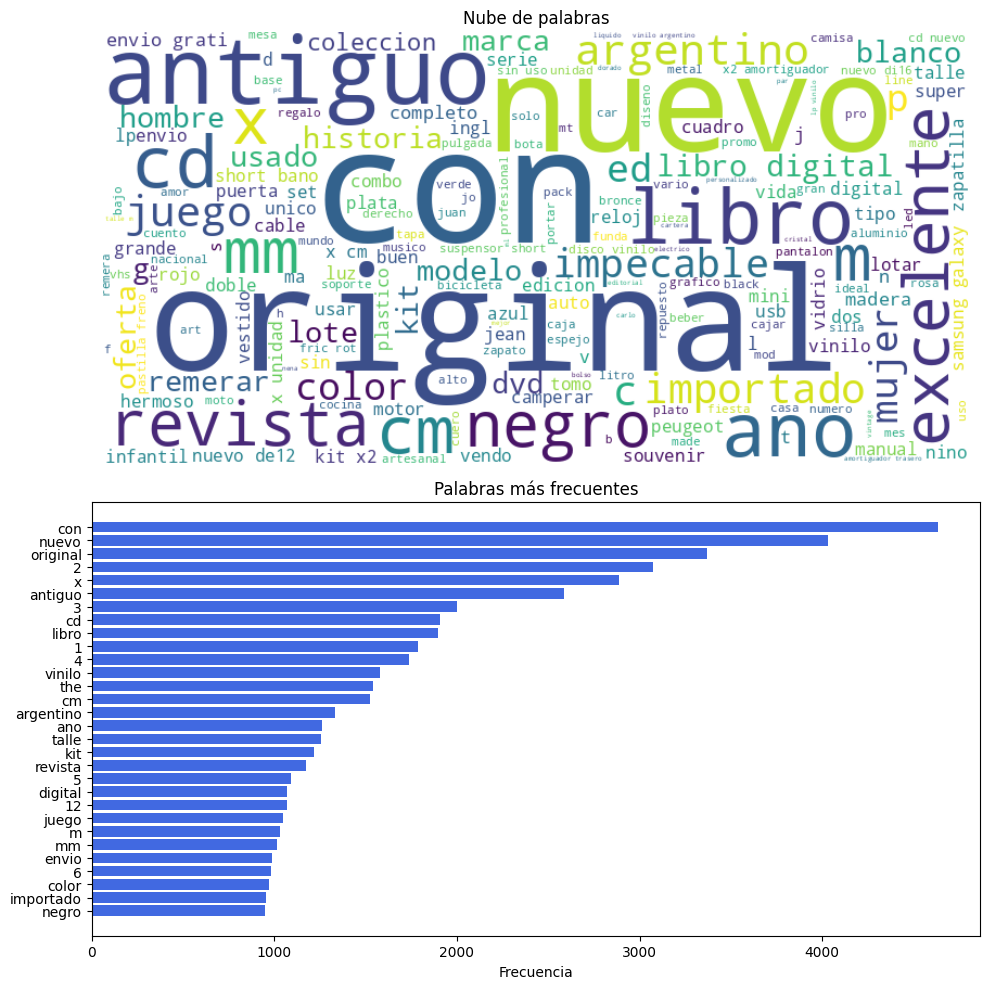

CPU times: user 11min 14s, sys: 7.06 s, total: 11min 21s
Wall time: 11min 34s


In [ ]:
%%time
df_temp = df_clean[df_clean['title'].notnull()] # Solo procesar la informacion con data
df_temp['title_clean'] = df_temp['title'].astype(str).map(
    lambda text: clean_text(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish'))
wordcloud_custom(df_temp, 'title_clean')

In [ ]:
top_value_counts(df_temp, 'title_clean', 'condition', 'new', 40)

,title_clean,count,percentage,cumulative_percentage
0,50 suspensor short bano tela calado,66,0.136499,0.136499
1,50 suspensor short bano nido abeja,43,0.088931,0.225430
2,confeccion short bano bermuda hombre nino,40,0.082727,0.308157
3,50 suspensor short bano tela nido abeja,30,0.062045,0.370202
4,camisa corte confeccion producto terminado,30,0.062045,0.432247
...,...,...,...,...
18545,juan falu tres pieza argentino guitarro h,1,0.002068,39.990073
18546,amor marguerite duro,1,0.002068,39.992141
18547,toner evertec cc531a c azul laserjet cp2020 20...,1,0.002068,39.994209
18548,impresionante botita gamuzo,1,0.002068,39.996277


In [ ]:
top_value_counts(df_temp, 'title_clean', 'condition', 'used', 40)

,title_clean,count,percentage,cumulative_percentage
0,item testeo favor ofertar,17,0.040818,0.040818
1,cartera cuero,6,0.014406,0.055225
2,zapato mujer,6,0.014406,0.069631
3,vestido fiesta,5,0.012005,0.081637
4,venta casa 3 ambiente parque sumampa ituzaingu...,4,0.009604,0.091241
...,...,...,...,...
16324,fortuna michael korda,1,0.002401,39.989915
16325,antiguo volante boxeo fab,1,0.002401,39.992317
16326,revista nippur magnum color numero 48,1,0.002401,39.994718
16327,edwin mansfield microeconomio teorio aplicacion,1,0.002401,39.997119


In [ ]:
df_clean[df_clean['title_clean'].str.contains('unico dueno')]['title']

,title


In [ ]:
%%time
def classify_product(text, **kwargs):
    """Clasifica el título en 'nuevo', 'usado' u 'otro' basándose en palabras clave."""

    # Normalización del texto
    text = clean_text(text, **kwargs)

    # Clasificación basada en palabras clave
    if re.search(r"\b(nuevo|flamante|original|precintado|sellado|estreno|intacto|sin uso|garantia|"
                 r"oficial|modelo|version|ultima|tecnologia|innovador|moderno|actual|premium|"
                 r"lanzamiento|digital|automatizado|optimizado|avanzado|mejorado|actualizado|"
                 r"profesional|full|completo|vanguardia|importado nuevo|exclusivo|primera mano|"
                 r"perfecto estado|accesorios nuevos|edicion limitada|garantia fabrica|full pack)\b", text):
        return "nuevo"

    elif re.search(r"\b(usado|segunda mano|antiguo|vintage|clasico|restaurado|reacondicionado|"
                   r"detalles|buen estado|desgastado|fallas|defectos|reparado|signos uso|"
                   r"funcionamiento correcto|original usado|deterioro|envejecido|descatalogado|"
                   r"discontinuado|unico dueno|coleccionista|retro|pieza antigua|raro|escaso|"
                   r"usado funcional|autentico|reparacion|adaptado|repuesto|cambio|segunda vida|"
                   r"estado conservacion|historico|modelo antiguo|desgaste normal|estructura original|"
                   r"restaurado profesional|manual funcionamiento|marca antigua|pieza unica)\b", text):
        return "usado"

    # Si no se clasifica en ninguna categoría, asignar "otro"
    return "otro"

# Aplicar la función a los títulos limpios
df_temp["title_class"] = df_temp["title"].apply(
    lambda text: classify_product(text, remove_sw=True, lemmatize=True, stem=False, use_regex=True, language='spanish')
)

# Ver los primeros resultados
df_temp[['title_clean', 'title_class']].head(10)

CPU times: user 11min 46s, sys: 8.39 s, total: 11min 54s
Wall time: 12min 9s


,title_clean,title_class
0,auricular samsung original mano libre cable us...,nuevo
1,cuchillo dacer acero carbon casco yelmo soling...,otro
2,antiguo revista billiken n 1826 ano 1954,usado
3,alarmar guardtex gx412 seguridad automotor,otro
4,serenata jennifer blake,otro
5,clavo olor12 grano origen turquia,otro
6,short nike fit boca juniors talle s 78 ano,otro
7,plazar toro iglesia visto aereas espana 1965,otro
8,kit x2 amortiguador trasero monroe chrysler ca...,otro
9,bonita malla color fuccia talle 1 2,otro


In [ ]:
df_temp[['condition', 'title_class']].value_counts()

condition  title_class
new        otro           39874
used       otro           35685
new        nuevo           7752
used       usado           3383
           nuevo           2580
new        usado            726
Name: count, dtype: int64

In [ ]:
df_clean['len_title'] = df_clean['title'].str.len()

In [ ]:
df_clean = df_clean.merge(df_temp[['index', 'title_class', 'title_clean']], on='index', how='left').drop(columns=['title', 'index'])

# 6 - Summary

1. Variables de envío ('shipping_tags', 'shipping_local_pick_up', 'shipping_free_shipping', 'shipping_mode'):
   - Se eliminó 'shipping_tags' debido a un alto porcentaje de valores erróneos.
   - Se mantienen 'shipping_local_pick_up', 'shipping_free_shipping' y 'shipping_mode' para analizar su relación con la condición del producto (nuevo/usado).
   - Preguntas clave: ¿Influyen los tipos de envío en la probabilidad de que un producto sea nuevo o usado?

2. Variables temporales ('stop_time', 'date_created', 'last_updated', 'start_time'):
   - Se convirtieron las columnas a objetos datetime.
   - Se calcularon nuevas variables:
       - 'time_to_start': Diferencia entre la fecha de creación y la fecha de inicio de la publicación.
       - 'listing_duration': Duración total de la publicación.
       - 'time_since_last_update': Tiempo transcurrido desde la última actualización.
   - Las variables originales de fecha y hora se eliminaron.
   - Preguntas clave: ¿Influye la antigüedad o duración de la publicación en la condición del producto?

3. Variables de imagen ('thumbnail', 'secure_thumbnail'):
   - Se eliminaron estas variables debido a la imposibilidad de acceder a las imágenes.

4. Variables del vendedor ('seller_id', 'seller_address_state.name', 'seller_address_country.name', 'seller_address_city.name'):
   - Se eliminó 'seller_id' por su alta cardinalidad y 'seller_address_country.name' por tener casi un solo valor (Argentina).
   - Se mantienen 'seller_address_state.name' y 'seller_address_city.name' para el análisis.
   - Preguntas clave: ¿Influye la ubicación del vendedor en la condición del producto?

5. Variable de modo de compra ('buying_mode'):
   - Se mantiene la variable para su posterior análisis, aunque se considera su posible eliminación debido al desbalance en sus valores (predominio de 'buy_it_now').
   - Preguntas clave: ¿Tiene relación el modo de compra con la condición del producto?

6. Variable de relista automática ('automatic_relist'):
  - Se mantiene para analizar su relación con la condición del producto, considerando el desbalance en sus valores.
  - Preguntas clave: ¿Afecta la relista automática la probabilidad de que un producto sea usado?

7. Variable de estado ('status'):
   - Se mantiene para analizar su relación con la condición del producto.
   - Preguntas clave: ¿Influye el estado de la publicación en la condición del producto?

8. Variables de categoría e identificadores ('category_id', 'currency_id', '0'):
   - Se eliminaron por considerarlas irrelevantes o auxiliares.

9. Variable de tipo de publicación ('listing_type_id'):
   - Se mantiene para analizar su relación con la condición del producto.
   - Preguntas clave: ¿Influye el tipo de publicación en la condición del producto?

10. Variable de aceptación de MercadoPago ('accepts_mercadopago'):
    - Se mantiene para analizar su posible relación con la condición del producto, considerando el desbalance.
    - Preguntas clave: ¿Tiene relación con la condición del producto?

11. Variable de título ('title'):
   - Se procesó el texto para limpiar caracteres especiales y stopwords, se evaluó la lematización, y se creó una variable 'title_class' categorizando los títulos en "nuevo", "usado" u "otro" basándose en palabras clave.
   - Se eliminó la columna 'title' original.
   - Se agregó una nueva columna 'len_title' con la longitud del título original
   - Se creó una nueva columna 'title_class', derivada de la limpieza y clasificación del texto del título.
   - Preguntas clave: ¿Se pueden categorizar los productos a partir de su título?
